# Flash MultiHead Attention test

In [2]:
from torch._C import dtype
!pip install torch
!pip install einops

import math
from collections import namedtuple
from functools import wraps
from packaging import version

import torch
from torch import nn, einsum, Tensor
import torch.nn.functional as F

from einops import rearrange

from dataclasses import dataclass

# constants

EfficientAttentionConfig = namedtuple('EfficientAttentionConfig', ['enable_flash', 'enable_math', 'enable_mem_efficient'])

# helpers

def exists(val):
    return val is not None

def once(fn):
    called = False
    @wraps(fn)
    def inner(x):
        nonlocal called
        if called:
            return
        called = True
        return fn(x)
    return inner

print_once = once(print)

# main class


@dataclass
class Intermediates:
    qk_similarities: Tensor = None
    pre_softmax_attn: Tensor = None
    post_softmax_attn: Tensor = None

    def to_tuple(self):
        return (self.qk_similarities, self.pre_softmax_attn, self.post_softmax_attn)

# helpers


class FlashAttention(nn.Module):
    def __init__(
        self,
        causal = False,
        dropout = 0.,
        flash = True
    ):
        super().__init__()
        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)

        self.causal = causal
        self.flash = flash
        assert not (flash and version.parse(torch.__version__) < version.parse('2.0.0')), 'in order to use flash attention, you must be using pytorch 2.0 or above'

        # determine efficient attention configs for cuda and cpu

        self.cpu_config = EfficientAttentionConfig(True, True, True)
        self.cuda_config = None

        if not torch.cuda.is_available() or not flash:
            return

        device_properties = torch.cuda.get_device_properties(torch.device('cuda'))

        if device_properties.major == 8 and device_properties.minor == 0:
            print_once('A100 GPU detected, using flash attention if input tensor is on cuda')
            self.cuda_config = EfficientAttentionConfig(True, False, False)
        else:
            print_once('Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda')
            self.cuda_config = EfficientAttentionConfig(False, True, True)

    def get_mask(self, i, j, device):
        return torch.ones((i, j), device=device, dtype=torch.bool).triu(j - i + 1)


    def flash_attn(
        self,
        q, k, v,
        mask = None,
        attn_bias = None
    ):
        batch, heads, q_len, _, k_len, is_cuda, device = *q.shape, k.shape[-2], q.is_cuda, q.device

        # Recommended for multi-query single-key-value attention by Tri Dao
        # kv shape torch.Size([1, 512, 64]) -> torch.Size([1, 8, 512, 64])

        if k.ndim == 3:
            k = rearrange(k, 'b ... -> b 1 ...').expand_as(q)

        if v.ndim == 3:
            v = rearrange(v, 'b ... -> b 1 ...').expand_as(q)

        # handle scale - by default they scale by dim_head ** -0.5, but need to take care if using cosine sim attention
        # Check if mask exists and expand to compatible shape
        # The mask is B L, so it would have to be expanded to B H N L

        causal = self.causal

        if exists(mask):
            assert mask.ndim == 4
            mask = mask.expand(batch, heads, q_len, k_len)

            # manually handle causal mask, if another mask was given

            if causal:
                causal_mask = self.create_causal_mask(q_len, k_len, device = device)
                mask = mask & ~causal_mask
                causal = False

        # handle alibi positional bias
        # convert from bool to float

        if exists(attn_bias):
            attn_bias = rearrange(attn_bias, 'h i j -> 1 h i j').expand(batch, -1, -1, -1)

            # if mask given, the mask would already contain the causal mask from above logic
            # otherwise, if no mask given but still causal, mask out alibi positional bias to a large negative number

            mask_value = -torch.finfo(q.dtype).max

            if exists(mask):
                attn_bias = attn_bias.masked_fill(~mask, mask_value // 2)
            elif causal:
                causal_mask = self.create_causal_mask(q_len, k_len, device = device)
                attn_bias = attn_bias.masked_fill(causal_mask, mask_value // 2)
                causal = False

            # scaled_dot_product_attention handles attn_mask either as bool or additive bias
            # make it an additive bias here

            mask = attn_bias

        # Check if there is a compatible device for flash attention

        config = self.cuda_config if is_cuda else self.cpu_config

        # pytorch 2.0 flash attn: q, k, v, mask, dropout, causal, softmax_scale

        with torch.backends.cuda.sdp_kernel(**config._asdict()):
            out = F.scaled_dot_product_attention(
                q, k, v,
                attn_mask = mask,
                dropout_p = self.dropout if self.training else 0.,
                is_causal = causal
            )

            return out

    def forward(self, q, k, v, mask = None, attn_bias = None):
        """
        einstein notation
        b - batch
        h - heads
        n, i, j - sequence length (base sequence length, source, target)
        d - feature dimension
        """

        q_len, k_len, device = q.shape[-2], k.shape[-2], q.device

        scale = q.shape[-1] ** -0.5

        kv_einsum_eq = 'b j d' if k.ndim == 3 else 'b h j d'

        if self.flash:
            return self.flash_attn(q, k, v, mask = mask, attn_bias = attn_bias)

        # similarity

        sim = einsum(f"b h i d, {kv_einsum_eq} -> b h i j", q, k) * scale

        # attention bias

        if exists(attn_bias):
            sim = sim + attn_bias

        # causal mask

        if self.causal:
            causal_mask = self.get_mask(q_len, k_len, device)
            sim = sim.masked_fill(causal_mask, -torch.finfo(sim.dtype).max)

        # attention

        attn = sim.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        # aggregate values

        out = einsum(f"b h i j, {kv_einsum_eq} -> b h i d", attn, v)

        return out


class FlashMHA(nn.Module):
    def __init__(self, embed_dim, num_heads, bias=True, batch_first=True, dropout=0.0,
                 causal=False, device=None, dtype=None) -> None:
        assert batch_first
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.causal = causal

        self.num_heads = num_heads
        assert self.embed_dim % num_heads == 0, "self.kdim must be divisible by num_heads"
        self.head_dim = self.embed_dim // num_heads
        assert self.head_dim % 8 == 0 and self.head_dim <= 128, "Only support head_dim <= 128 and divisible by 8"

        self.Wqkv = nn.Linear(embed_dim, 3 * embed_dim, bias=bias, **factory_kwargs)
        self.inner_attn = FlashAttention(dropout=dropout, causal=causal)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias, **factory_kwargs)

    def forward(self, query, key, value):
        qkv = self.Wqkv(query)
        q, k, v = rearrange(qkv, 'b s (three h d) -> three b s h d', three=3, h=self.num_heads, d=self.head_dim).unbind(dim=0)
        context = self.inner_attn(q, k, v)
        return self.out_proj(rearrange(context, 'b s h d -> b s (h d)'))

In [74]:
import torch

# Example 1
flash_mha = FlashMHA(embed_dim=512, num_heads=8, dropout=0.1)
query = torch.randn(10, 32, 512)  # sequence length = 10, batch size = 32, embedding dimension = 512
key = torch.randn(10, 32, 512)
value = torch.randn(10, 32, 512)
output = flash_mha(query, key, value)
print(output[0].shape)  # should be [10, 32, 512]

# Example 2
flash_mha = FlashMHA(embed_dim=256, num_heads=4, dropout=0.0)
query = torch.randn(20, 16, 256)  # sequence length = 20, batch size = 16, embedding dimension = 256
key = torch.randn(20, 16, 256)
value = torch.randn(20, 16, 256)
output = flash_mha(query, key, value)
print(output[0].shape)  # should be [20, 16, 256]

# Example 3
flash_mha = FlashMHA(embed_dim=128, num_heads=2, dropout=0.2)
query = torch.randn(30, 64, 128)  # sequence length = 30, batch size = 64, embedding dimension = 128
key = torch.randn(30, 64, 128)
value = torch.randn(30, 64, 128)
output = flash_mha(query, key, value)
print(output[0].shape)  # should be [30, 64, 128]

torch.Size([32, 512])
torch.Size([16, 256])
torch.Size([64, 128])


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


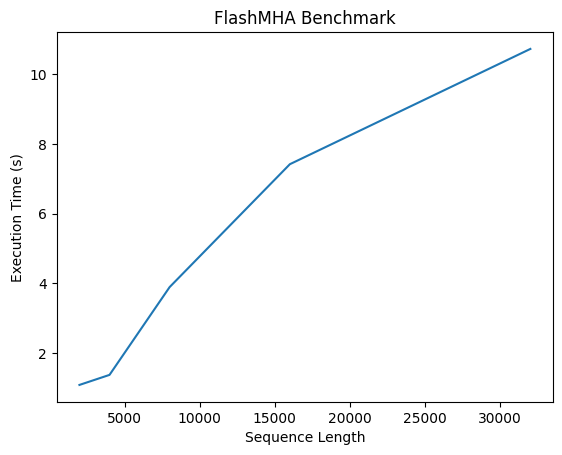

In [3]:
import timeit
import matplotlib.pyplot as plt

# Initialize the model
flash_mha = FlashMHA(embed_dim=512, num_heads=8, bias=True, batch_first=True, dropout=0.5, causal=False)

# Define the sequence lengths for the benchmark
seq_lengths = [2000, 4000, 8000, 16000, 32000]

# Store the execution times
exec_times = []

for seq_len in seq_lengths:
    # Create input tensors
    query = torch.randn(10, seq_len, 512)
    key = torch.randn(10, seq_len, 512)
    value = torch.randn(10, seq_len, 512)

    # Measure the execution time
    start_time = timeit.default_timer()
    output = flash_mha(query, key, value)
    exec_time = timeit.default_timer() - start_time

    exec_times.append(exec_time)

# Plot the execution time against the sequence length
plt.plot(seq_lengths, exec_times)
plt.xlabel('Sequence Length')
plt.ylabel('Execution Time (s)')
plt.title('FlashMHA Benchmark')
plt.show()

In [ ]:
import timeit
import matplotlib.pyplot as plt

# Initialize the model
flash_attention = FlashAttention(causal=False, dropout=0.0)

# Define the sequence lengths for the benchmark
seq_lengths = [2000, 4000, 8000, 16000, 32000]

# Store the execution times
exec_times = []

for seq_len in seq_lengths:
    #create input tensors
    query = torch.randn(10, 8, seq_len, 64) #added dimension for the attention heads
    key = torch.randn(10, 8, seq_len, 64) # added dimension for the number of attention heads
    value = torch.randn(10, 8, seq_len, 64) # added dimension for the number of attention heads

    #measure the execution time
    start_time = timeit.default_timer()
    output = flash_attention.forward(query, key, value)
    exec_time = timeit.default_timer() - start_time

    exec_times.append(exec_time)

# Plot the execution time against the sequence length
plt.plot(seq_lengths, exec_times)
plt.xlabel('Sequence Length')
plt.ylabel('Execution Time (s)')
plt.title('FlashAttention Benchmark')
plt.show()
